# はじめに
ニューラルネットワークの予測の不確実性を算出する手法を検証します。

### 概要
- 連続値を予測する回帰のためのニューラルネットワークを構築
- stochastic variational inference で予測の不確実性を算出


# 事前準備（変分ベイズ）
前提知識として必要なベイズ推論と変分推論について説明します。  

### ベイズ推論  
通常のニューラルネットワークでは、出力は変数ですが、ベイズ推論ではラベル$y$の分布$p(y|x)$を考えます。  
分布が尖った形になっている場合は予測の不確実性が低く、裾が広い場合は不確実性が高いことになります。  

ラベルの分布は、パラメータの分布$p(\theta)$を考え、積分で$\theta$を消去することで求めます。  
$$
p(y|x) = \int p(y|x, \theta)p(\theta) {\rm d}\theta
$$

### 変分推論
パラメータの事後分布$p(\theta|X,Y)$を、計算しやすい分布$q(\theta)$で近似することを考えます。  
近似分布$q(\theta)$は、$p(\theta|X,Y)$とのKLダイバージェンスが小さければ、よい近似となります。  
$$
D_{KL}[q(\theta)||p(\theta|X,Y)] = \int q(\theta)\ln\frac{q(\theta)}{p(\theta|X,Y)} {\rm d}\theta
$$

しかし、直接最小化することは難しいため、データの周辺分布 $\ln p(X,Y)$ とその下界（ELBO）$\mathcal{L}(\xi)$ を考えます。  
これらと、上記KLダイバージェンスには、下記の関係があることが知られています。
$$
\ln p(X,Y) = \mathcal{L}(\xi) + D_{KL}[q(\theta;\xi)||p(\theta|X,Y)]
$$
ここで、$\xi$は$q(\theta)$の形を決めるパラメータで、変分推論では$\xi$を最適化します。  

この関係性を用いて、KLダイバージェンスを最小化する問題を、ELBOを最大化する問題に置き換えます。  
ELBOは下記で定義されます。
$$
\mathcal{L}(\xi) = \int q(\theta;\xi)\ln \frac{p(X,Y,\theta)}{q(\theta;\xi)} {\rm d}\theta
$$

同時確率を条件付き確率に書き換えると、$p(X,Y,\theta)=p(Y|X,\theta)p(X|\theta)p(\theta)$となり、$X$と$\theta$は独立のため $p(X,Y,\theta)=p(Y|X,\theta)p(X)p(\theta)$ と書くことができます。  
これをELBOに代入すると下記のようになります。  
$$
\mathcal{L}(\xi) = \int q(\theta;\xi) \ln p(Y|X, \theta) {\rm d}\theta + \int q(\theta;\xi) \ln p(X) {\rm d}\theta + \int q(\theta;\xi) \ln \frac{p(\theta)}{q(\theta;\xi)} {\rm d}\theta \\
= \mathbb{E}_{q(\theta;\xi)}[\ln p(Y|X, \theta)] + \ln p(X) - D_{KL}[q(\theta;\xi)||p(\theta)]
$$

$\ln p(X)$は定数なので、ELBOを最大化するために、下記の負の対数尤度と$q(\theta)$とパラメータの事前分布とのKLダイバージェンスの和を最小化すればよいことが分かります。  
$$
\mathbb{E}_{q(\theta;\xi)}[-\ln p(Y|X, \theta)] + D_{KL}[q(\theta;\xi)||p(\theta)]
$$

# Stochastic Variational Inference
負の対数尤度の期待値を最小化するために、各バッチで$q(\theta;\xi)$からパラメータをサンプリングして、そのパラメータでの負の対数尤度を最小化します。  
$q(\theta;\xi)$は勾配降下法で最適化できる必要があるため、$q(\theta;\xi)$の実装では下記のような方法が用いられます。

### reparametrization trick
$q(\theta;\xi)$を、平均$\mu$、標準偏差$\sigma^2$の正規分布$\mathcal{N}(\mu,\sigma^2)$からサンプリングする場合、まず、平均0、標準偏差1の正規分布に従うノイズ$\epsilon \sim \mathcal{N}(0,1)$をサンプリングし、$\theta = \mu + \sigma^2 \epsilon$をパラメータとして用います。  
$\mu$と$\sigma$を勾配降下法で最適化します。

### flipout
上記の手法だと、ミニバッチ内のサンプルで$\epsilon$が共有されてしまう問題があります。  
そこで、ノイズにランダムな符号ベクトル$r_ns_n^T$をかけ、$\theta=\mu + \sigma^2\epsilon r_ns_n^T$を用いることで、学習を効率化します。  


### 回帰タスクの対数尤度  
サンプリングされたパラメータ$\theta$でのデータ$x$の予測を$p(y|x,\theta)=\mathcal{N}(f(x;\theta),\sigma^2)$、正解を$y$とすると、対数尤度は$\ln p(y|x,\theta)=-\frac{\ln 2\pi\sigma^2}{2} - \frac{(y-f(x;\theta))^2}{2\sigma^2}$となります。  
つまり、負の対数尤度を最小化するためには、2乗誤差を最小化すればよいことになります。

### 不確実性の算出  
近似分布$q(\theta;\xi)$からn個のパラメータ$\{\theta_1, \cdots, \theta_n\}$をサンプリングし、事後分布の期待値と分散を計算します。  

$$
\mu(y) = \frac{1}{n}\sum_{i=1}^n f(x;\theta_i)
$$
$$
{\rm Var}(y) = \sigma^2 + \frac{1}{n}\sum_{i=1}^n f(x;\theta_i)^T f(x;\theta_i) - \mu(y)^T \mu(y)
$$


# 学習のまとめ
Stochastic variational inferenceでは、各ミニバッチで近似分布$q(\theta)$からパラメータ$\theta$をサンプリングし、平均二乗誤差と事前分布と近似分布のKLダイバージェンスを最小化します。  
$$
\mathcal{L} = \frac{1}{n} \sum_{i=1}^n (y_n - f(x_n;\theta))^2 + \alpha D_{KL}[q(\theta)||p(\theta)]
$$
ここで、$\alpha$は、2つの項のバランスを調整するパラメータです。










# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install bayesian-torch
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 1.8 MB/s eta 0:00:00


### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  
[Google Colaboratory](https://colab.research.google.com/?hl=ja)で実行した際の例になります。

In [2]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
!nvidia-smi

Python: 3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
PyTorch: 2.0.1+cu118
Sat Jul 22 07:06:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
         

### 3. データセットの作成  
sinカーブに従うデータを作成します。  
ただし、学習には[-1,1]の範囲のデータは使用しません。



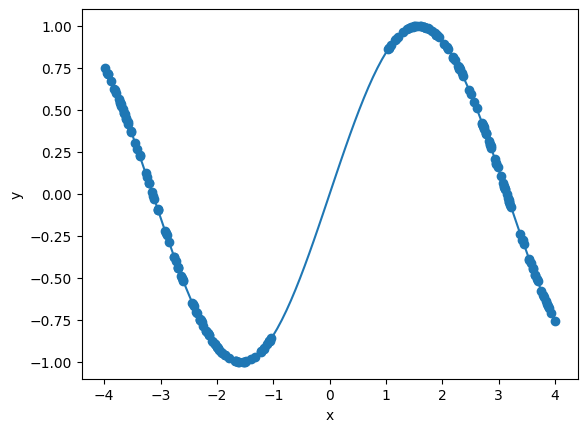

In [5]:
def make_dataset(seed, plot=0, batch_size=64):
    np.random.seed(seed)

    x_true = np.linspace(-4, 4, 100)
    y_true = np.sin(x_true)

    x = np.concatenate([np.random.uniform(-4, -1, 100), np.random.uniform(1, 4, 100)])
    y = np.sin(x)

    # データをPyTorchのテンソルに変換
    x = torch.from_numpy(x).float().view(-1, 1)
    y = torch.from_numpy(y).float().view(-1, 1)
    x_true = torch.from_numpy(x_true).float().view(-1, 1)

    # グラフを描画
    if plot == 1:
        plt.plot(x_true, y_true)
        plt.scatter(x, y)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

    dataset = torch.utils.data.TensorDataset(x, y)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader

_ = make_dataset(0, plot=1)

### ニューラルネットワークの定義
今回は3層の全結合ニューラルネットワークを用います。

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### 4. 学習
[Bayesian Torch](https://github.com/IntelLabs/bayesian-torch) を用いてstochastic variational inferenceの学習を行います。  
flipoutとreoarameterizationを選択できますが、今回はflipoutを使用します。


In [15]:
batch_size=64
data_loader = make_dataset(0, batch_size=batch_size)

model = Net()
const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Flipout",  # Flipout or Reparameterization,
        "moped_enable": False,
        }
dnn_to_bnn(model, const_bnn_prior_parameters)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
num_epochs = 1000
for epoch in range(num_epochs):
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        y_pred = model(inputs)

        # KLダイバージェンスの計算
        kl = get_kl_loss(model)

        # 損失の計算
        loss = criterion(y_pred, targets) + 1e-4 * kl / batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


### 5. 予測
予測の平均と標準偏差を描画します。


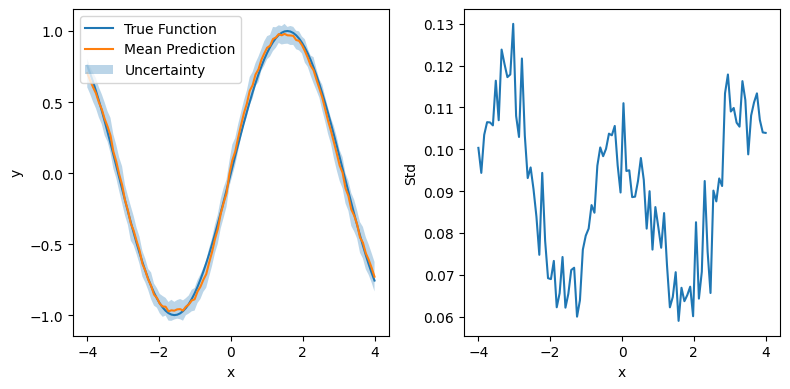

In [17]:
x_true = np.linspace(-4, 4, 100)
y_true = np.sin(x_true)
x_true = torch.from_numpy(x_true).float().view(-1, 1)

model.eval()
x_true = x_true.to(device)
y_preds = []
for _ in range(100):
    with torch.no_grad():
        y_pred = model(x_true)
    y_preds.append(y_pred.to('cpu').detach().numpy())

x_true = x_true.to('cpu')
y_preds = np.array(y_preds)
y_mean = np.mean(y_preds, axis=0)
y_std = np.sqrt(np.var(y_preds, axis=0) + 1e-4/2)


# グラフの描画
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.plot(x_true, y_true, label='True Function')
plt.plot(x_true, y_mean, label='Mean Prediction')
plt.fill_between(x_true.flatten(), y_mean.flatten() - y_std.flatten(), y_mean.flatten() + y_std.flatten(), alpha=0.3, label='Uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()


plt.subplot(122)
plt.plot(x_true, y_std)
plt.xlabel('x')
plt.ylabel('Std')

plt.tight_layout()
plt.show()

plt.show()

# おわりに


### 今回の結果
予測の不確実性は、x最小値および最大値付近とデータが含まれない[-1,1]の範囲で大きくなっています。  
データ数が少なく、予測が不確実と考えられる領域と、予測の標準偏差が大きい領域が一致しているため、想定通り予測の不確実性が算出できていると考えられます。  

### 次にやること
予測の不確実性を算出する他の手法も検証したいと思います。  

### 参考資料
- D. P. Kingma and M. Welling, Auto-Encoding Variational Bayes, ICLR, 2014
- Y. Wen et al., Flipout: Efficient Pseudo-Independent Weight Perturbations on Mini-batches, ICLR, 2018.
- Bayesian Torch  
https://github.com/IntelLabs/bayesian-torch


